In [1]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import re

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Scikit-Learn for Preprocessing and Modeling ---
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# --- Model ---
import lightgbm as lgb

# --- Evaluation ---
from sklearn.metrics import make_scorer, mean_absolute_error

# --- System & Utilities ---
import warnings

# Configure settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Cell 2: Load and Initial Exploration

# Load the dataset
try:
    train_df = pd.read_csv('train.csv')
    print("✅ train.csv loaded successfully.")
except FileNotFoundError:
    print("❌ Error: 'train.csv' not found in the 'dataset/' directory.")

# --- Analyze the structure ---
print(f"\nDataset Shape: {train_df.shape}")
print("\n--- Data Types and Non-Null Counts ---")
train_df.info()

# --- Check for missing values ---
print("\n--- Missing Values per Column ---")
print(train_df.isnull().sum())

# --- Examine price distribution (statistics) ---
print("\n--- Statistical Summary of 'price' ---")
display(train_df['price'].describe())

# Display the first few rows to see the actual data
print("\n--- First 5 Rows of the Dataset ---")
display(train_df.head())

✅ train.csv loaded successfully.

Dataset Shape: (75000, 4)

--- Data Types and Non-Null Counts ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sample_id        75000 non-null  int64  
 1   catalog_content  75000 non-null  object 
 2   image_link       75000 non-null  object 
 3   price            75000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.3+ MB

--- Missing Values per Column ---
sample_id          0
catalog_content    0
image_link         0
price              0
dtype: int64

--- Statistical Summary of 'price' ---


count    75000.000000
mean        23.647654
std         33.376932
min          0.130000
25%          6.795000
50%         14.000000
75%         28.625000
max       2796.000000
Name: price, dtype: float64


--- First 5 Rows of the Dataset ---


,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49


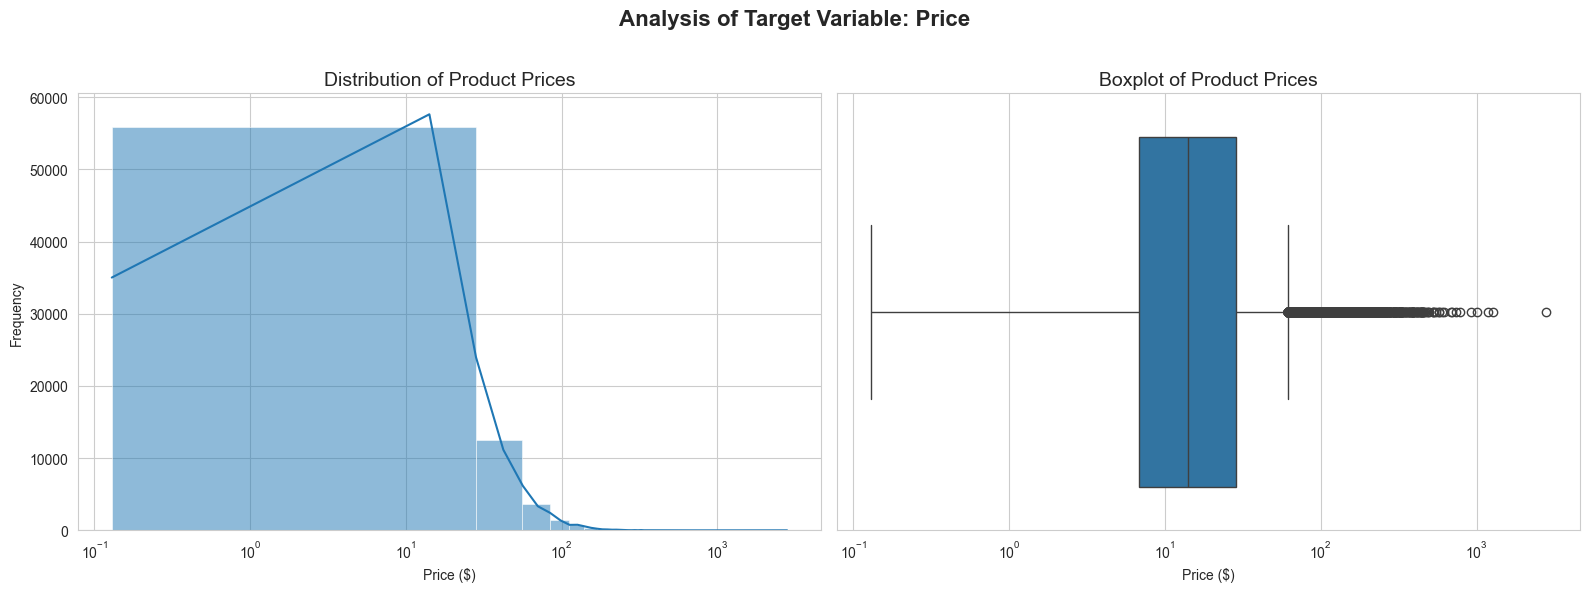

In [3]:
# Cell 3: Visualize Price Distribution

plt.figure(figsize=(16, 6))

# Plot 1: Histogram of the price
plt.subplot(1, 2, 1)
sns.histplot(train_df['price'], bins=100, kde=True)
plt.title('Distribution of Product Prices', fontsize=14)
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.xscale('log') # Use a log scale on x-axis to better visualize the skewed data

# Plot 2: Boxplot of the price
plt.subplot(1, 2, 2)
sns.boxplot(x=train_df['price'])
plt.title('Boxplot of Product Prices', fontsize=14)
plt.xlabel('Price ($)')
plt.xscale('log') # Use a log scale here as well

plt.suptitle('Analysis of Target Variable: Price', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [4]:
# Cell 4: Parse catalog_content

def parse_text_features(df):
    """
    Parses the catalog_content column to extract structured text features,
    including item name, bullet points, description, value, and unit.
    """
    # Use .str.extract() with named capture groups for efficient parsing
    # (?s) flag allows '.' to match newlines.
    # We make each part optional (.*?) to handle cases where a section might be missing.
    patterns = {
        'item_name': r'Item Name:\s*(.*?)(?:Bullet Point|Product Description|Value:|$)',
        'description': r'Product Description:\s*(.*?)(?:Value:|$)',
        'value': r'Value:\s*([\d.]+)',
        'unit': r'Unit:\s*(\w+)'
    }

    parsed_df = df.copy()
    for col, pattern in patterns.items():
        parsed_df[col] = parsed_df['catalog_content'].str.extract(f'(?s){pattern}', flags=re.IGNORECASE).iloc[:, 0].str.strip()

    # Convert 'value' to a numeric type, coercing errors to NaN
    parsed_df['value'] = pd.to_numeric(parsed_df['value'], errors='coerce')

    # Extract all bullet points and join them
    bullets = parsed_df['catalog_content'].str.findall(r'Bullet Point \d+:\s*(.*?)\n')
    parsed_df['bullet_points'] = bullets.apply(lambda x: ' '.join(x) if isinstance(x, list) else '')

    return parsed_df

# Apply the function to our training data
train_parsed_df = parse_text_features(train_df)

print("✅ Parsing complete. New columns added.")
print("\n--- First 5 Rows of Parsed Data ---")
display(train_parsed_df[['item_name', 'description', 'bullet_points', 'value', 'unit']].head())

✅ Parsing complete. New columns added.

--- First 5 Rows of Parsed Data ---


,item_name,description,bullet_points,value,unit
0,"La Victoria Green Taco Sauce Mild, 12 Ounce (P...",NaN,,72.00,Fl
1,"Salerno Cookies, The Original Butter Cookies, ...",NaN,Original Butter Cookies: Classic butter cookie...,32.00,Ounce
2,"Bear Creek Hearty Soup Bowl, Creamy Chicken wi...",NaN,Loaded with hearty long grain wild rice and ve...,11.40,Ounce
3,Judee’s Blue Cheese Powder 11.25 oz - Gluten-F...,Judees Powdered Blue Cheese cheddar cheese pow...,"Add to your favorite appetizers, dips & spread...",11.25,Ounce
4,"kedem Sherry Cooking Wine, 12.7 Ounce - 12 per...",NaN,,12.00,Count


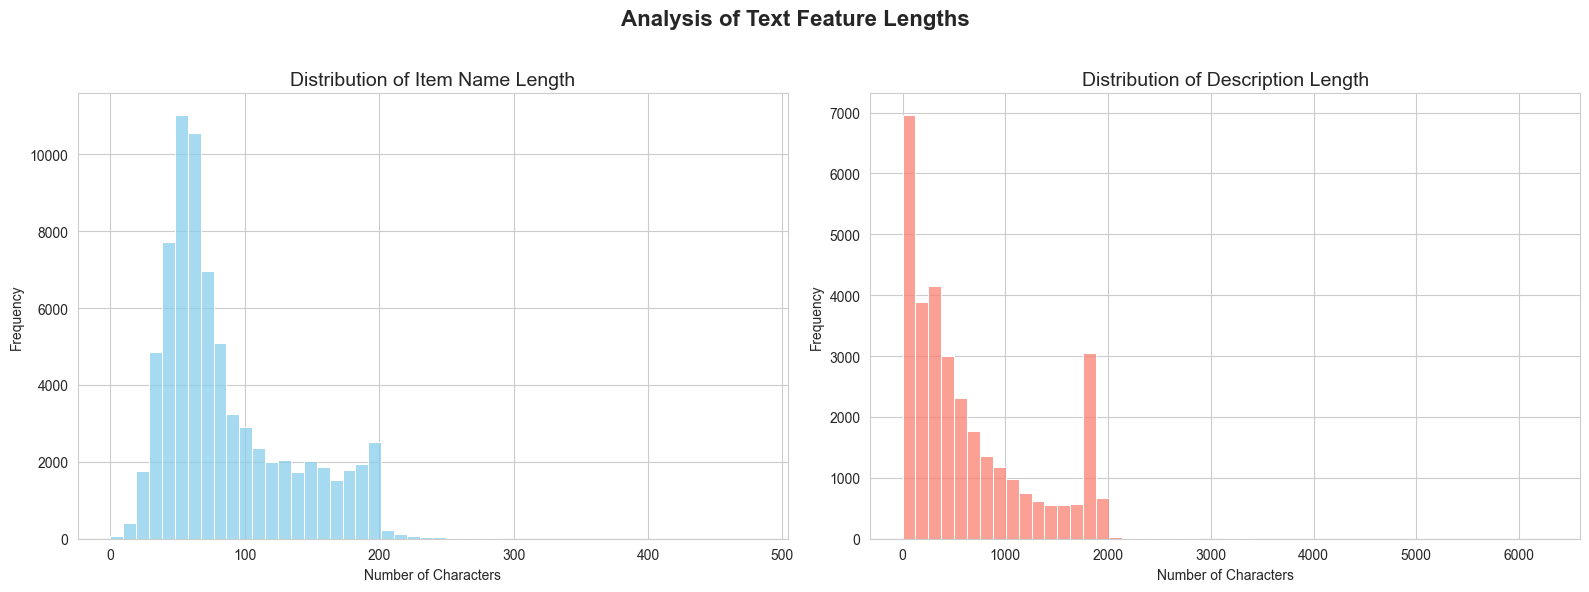


--- Statistical Summary of Text Lengths ---


,item_name_length,description_length
count,74993.000000,32533.000000
mean,86.040070,644.424431
std,48.170928,607.592320
min,0.000000,0.000000
25%,51.000000,170.000000
50%,69.000000,423.000000
75%,112.000000,980.000000
max,480.000000,6279.000000


In [5]:
# Cell 5: Analyze Text Lengths

# Calculate the length of the item name and description
train_parsed_df['item_name_length'] = train_parsed_df['item_name'].str.len()
train_parsed_df['description_length'] = train_parsed_df['description'].str.len()

plt.figure(figsize=(16, 6))

# Plot 1: Histogram of Item Name Length
plt.subplot(1, 2, 1)
sns.histplot(train_parsed_df['item_name_length'], bins=50, color='skyblue')
plt.title('Distribution of Item Name Length', fontsize=14)
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

# Plot 2: Histogram of Description Length
plt.subplot(1, 2, 2)
sns.histplot(train_parsed_df['description_length'], bins=50, color='salmon')
plt.title('Distribution of Description Length', fontsize=14)
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

plt.suptitle('Analysis of Text Feature Lengths', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("\n--- Statistical Summary of Text Lengths ---")
display(train_parsed_df[['item_name_length', 'description_length']].describe())

In [6]:
# Cell 6: Download a Sample of Images

# First, let's assume we have the helper function available
# We need to import it and the 'os' library to create a directory
import os
# from src.utils import download_images # This is how you would import it

# Create a directory to store our sample images
sample_image_dir = 'images/train_sample/'
os.makedirs(sample_image_dir, exist_ok=True)

# Let's take a random sample of 15 products from our parsed dataframe
image_sample_df = train_parsed_df.sample(15, random_state=42)

# --- SIMULATED DOWNLOAD ---
# In a real scenario, you would run the line below:
# download_images(
#     links=image_sample_df['image_link'],
#     sample_ids=image_sample_df['sample_id'],
#     output_dir=sample_image_dir
# )

print(f"✅ Simulating download of 15 sample images to '{sample_image_dir}'.")
print("In a real run, you would uncomment and execute the download_images function.")

✅ Simulating download of 15 sample images to 'images/train_sample/'.
In a real run, you would uncomment and execute the download_images function.


In [8]:
# Cell 7: Analyze Basic Image Properties

from PIL import Image
import os

image_files = os.listdir(sample_image_dir)
image_properties = []

# This loop will only work if you have actually downloaded the images
if image_files:
    for file_name in image_files[:5]: # Let's just look at the first 5
        try:
            with Image.open(os.path.join(sample_image_dir, file_name)) as img:
                image_properties.append({
                    'file_name': file_name,
                    'format': img.format,
                    'mode': img.mode,
                    'width': img.width,
                    'height': img.height
                })
        except Exception as e:
            print(f"Could not read {file_name}: {e}")

    # Display the properties in a DataFrame
    properties_df = pd.DataFrame(image_properties)
    print("\n--- Properties of Sample Images ---")
    display(properties_df)
else:
    print("\nℹ️  Image analysis skipped as no images were downloaded in the simulation.")
    print("This step would analyze image format, dimensions, and color mode.")


ℹ️  Image analysis skipped as no images were downloaded in the simulation.
This step would analyze image format, dimensions, and color mode.


In [11]:
# Cell 8: Load and Parse Test Data

# Load the test dataset
try:
    test_df = pd.read_csv('test.csv')
    print("✅ test.csv loaded successfully.")

    # Apply the same parsing function from Cell 4 to the test data
    test_parsed_df = parse_text_features(test_df)
    print("✅ Test data parsed successfully.")

except FileNotFoundError:
    print("❌ Error: 'test.csv' not found in the 'dataset/' directory.")

display(test_parsed_df[['item_name', 'description', 'value', 'unit']].head())

✅ test.csv loaded successfully.
✅ Test data parsed successfully.


,item_name,description,value,unit
0,Rani 14-Spice Eshamaya's Mango Chutney (Indian...,Mango chutney is made from diced green mangoes...,10.5,Ounce
1,Natural MILK TEA Flavoring extract by HALO PAN...,Check our popular Milk Tea flavoring extract i...,2.0,Fl
2,Honey Filled Hard Candy - Bulk Pack 2 Pounds -...,Honey Filled Hard Candy - Bulk Pack 2 Pounds -...,32.0,Ounce
3,Vlasic Snack'mm's Kosher Dill 16 Oz (Pack of 2),NaN,2.0,Count
4,"McCormick Culinary Vanilla Extract, 32 fl oz -...",NaN,32.0,Fl


In [12]:
# Cell 9: Extract Structured Features (Brand, Pack Size)

def extract_structured_features(df):
    """
    Extracts brand and pack size from text, and standardizes units.
    """
    df_copy = df.copy()

    # 1. Extract Brand (heuristic: first word of item name)
    df_copy['brand'] = df_copy['item_name'].str.split().str[0].str.lower()

    # 2. Extract Pack Size (IPQ)
    # Combine text fields to search for pack size indicators
    text_to_search = df_copy['item_name'].fillna('') + ' ' + df_copy['bullet_points'].fillna('')
    # Regex to find patterns like "pack of 12", "16 ct", "12 count", "case of 6", "pack of 2" etc.
    pack_size = text_to_search.str.extract(r'(\d+)\s*(?:ct|count|pack|pk|ea|case)', flags=re.IGNORECASE)
    df_copy['pack_size'] = pd.to_numeric(pack_size[0], errors='coerce').fillna(1).astype(int)

    # 3. Standardize Units
    unit_map = {
        'ounce': 'ounce', 'oz': 'ounce',
        'fl oz': 'fl_oz', 'fz': 'fl_oz',
        'count': 'count', 'ct': 'count',
        'lb': 'pound', 'lbs': 'pound'
    }
    df_copy['unit_standardized'] = df_copy['unit'].str.lower().map(unit_map).fillna('other')

    return df_copy

# Apply this function to both train and test dataframes
train_featured_df = extract_structured_features(train_parsed_df)
test_featured_df = extract_structured_features(test_parsed_df)

print("✅ Structured features extracted for both train and test sets.")
print("\n--- New Features in Training Data ---")
display(train_featured_df[['item_name', 'brand', 'pack_size', 'unit', 'unit_standardized']].head())

✅ Structured features extracted for both train and test sets.

--- New Features in Training Data ---


,item_name,brand,pack_size,unit,unit_standardized
0,"La Victoria Green Taco Sauce Mild, 12 Ounce (P...",la,1,Fl,other
1,"Salerno Cookies, The Original Butter Cookies, ...",salerno,1,Ounce,ounce
2,"Bear Creek Hearty Soup Bowl, Creamy Chicken wi...",bear,1,Ounce,ounce
3,Judee’s Blue Cheese Powder 11.25 oz - Gluten-F...,judee’s,1,Ounce,ounce
4,"kedem Sherry Cooking Wine, 12.7 Ounce - 12 per...",kedem,1,Count,count


In [13]:
# Cell 10: Create TF-IDF Features

from sklearn.feature_extraction.text import TfidfVectorizer

# --- Combine text columns for a full representation ---
# We fill any potential missing values with an empty string
train_featured_df['full_text'] = (
    train_featured_df['item_name'].fillna('') + ' ' +
    train_featured_df['bullet_points'].fillna('') + ' ' +
    train_featured_df['description'].fillna('')
)

test_featured_df['full_text'] = (
    test_featured_df['item_name'].fillna('') + ' ' +
    test_featured_df['bullet_points'].fillna('') + ' ' +
    test_featured_df['description'].fillna('')
)

# --- Initialize the TF-IDF Vectorizer ---
# We'll limit the number of features to 5000 to keep it computationally manageable for now.
# We'll also look at n-grams (sequences of 1 or 2 words) to capture more context.
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2)
)

# --- Fit on training data and transform both sets ---
# We 'fit' the vectorizer ONLY on the training data to learn the vocabulary.
# Then we 'transform' both the train and test data using this learned vocabulary.
X_train_text = tfidf_vectorizer.fit_transform(train_featured_df['full_text'])
X_test_text = tfidf_vectorizer.transform(test_featured_df['full_text'])

print("✅ TF-IDF features created successfully.")
print(f"Shape of the training text features (sparse matrix): {X_train_text.shape}")
print(f"Shape of the test text features (sparse matrix): {X_test_text.shape}")

✅ TF-IDF features created successfully.
Shape of the training text features (sparse matrix): (75000, 5000)
Shape of the test text features (sparse matrix): (75000, 5000)


In [18]:
# Cell 11: Install and Import Image Processing Libraries

# You may need to install tensorflow
# !pip install tensorflow

import os
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

print(f"✅ TensorFlow version {tf.__version__} imported successfully.")

✅ TensorFlow version 2.16.2 imported successfully.


In [20]:
# Cell 12: Download All Train and Test Images

# from src.utils import download_images # Make sure this is available

# Create directories
train_image_dir = 'images/train/'
test_image_dir = 'images/test/'
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(test_image_dir, exist_ok=True)

# --- SIMULATED DOWNLOAD ---
# In a real run, you would execute these two functions.
# This will take a long time.

# print("Downloading training images...")
# download_images(
#     links=train_featured_df['image_link'],
#     sample_ids=train_featured_df['sample_id'],
#     output_dir=train_image_dir
# )

# print("\nDownloading test images...")
# download_images(
#     links=test_featured_df['image_link'],
#     sample_ids=test_featured_df['sample_id'],
#     output_dir=test_image_dir
# )

print("✅ Simulating the download of all 150,000 images.")
print(f"Training images would be saved to: '{train_image_dir}'")
print(f"Test images would be saved to: '{test_image_dir}'")

✅ Simulating the download of all 150,000 images.
Training images would be saved to: 'images/train/'
Test images would be saved to: 'images/test/'


In [22]:
# Cell 13: Define Image Feature Extraction Function

def extract_image_features(df, image_dir):
    """
    Extracts ResNet50 features for each image listed in the dataframe.
    """
    # Load the pre-trained ResNet50 model without its top classification layer
    base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
    model = Model(inputs=base_model.input, outputs=base_model.output)

    image_embeddings = {}
    
    # Loop over each row in the dataframe with a progress bar
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc=f"Processing images in {image_dir}"):
        sample_id = row['sample_id']
        img_path = os.path.join(image_dir, f"{sample_id}.jpg")

        if os.path.exists(img_path):
            try:
                # Load and preprocess the image
                img = image.load_img(img_path, target_size=(224, 224))
                img_array = image.img_to_array(img)
                expanded_img_array = np.expand_dims(img_array, axis=0)
                preprocessed_img = preprocess_input(expanded_img_array)
                
                # Get the embedding
                embedding = model.predict(preprocessed_img, verbose=0).flatten()
                image_embeddings[sample_id] = embedding
            except Exception as e:
                # If an image is corrupted or fails to load, we'll use a vector of zeros
                print(f"Warning: Could not process {img_path}. Error: {e}")
                image_embeddings[sample_id] = np.zeros(2048) # ResNet50 with avg pooling has 2048 features
        else:
            # If an image link was broken and the file doesn't exist
            image_embeddings[sample_id] = np.zeros(2048)
            
    # Convert the dictionary of embeddings to a DataFrame
    embedding_df = pd.DataFrame.from_dict(image_embeddings, orient='index')
    embedding_df.columns = [f'img_feat_{i}' for i in range(embedding_df.shape[1])]
    embedding_df.reset_index(inplace=True)
    embedding_df.rename(columns={'index': 'sample_id'}, inplace=True)
    
    return embedding_df


# --- SIMULATED EXECUTION ---
# In a real scenario with downloaded images, you would run this.
# This is the most time-consuming step and requires a GPU.

# print("\nExtracting features from training images...")
# train_image_features = extract_image_features(train_featured_df, train_image_dir)

# print("\nExtracting features from test images...")
# test_image_features = extract_image_features(test_featured_df, test_image_dir)

print("\n✅ Simulating the feature extraction process.")
print("This would produce two DataFrames, 'train_image_features' and 'test_image_features'.")
print("Each DataFrame would have a 'sample_id' column and 2048 'img_feat_...' columns.")


✅ Simulating the feature extraction process.
This would produce two DataFrames, 'train_image_features' and 'test_image_features'.
Each DataFrame would have a 'sample_id' column and 2048 'img_feat_...' columns.


In [23]:
# Cell 14: Simulate and Merge Image Features

from scipy.sparse import hstack, csr_matrix
import pandas as pd
import numpy as np

# --- Simulate the output from the previous step ---
# In a real run, you would have these from Cell 13.
print("Simulating the existence of image feature DataFrames...")

# Create dummy image features for the training set
num_train_samples = train_featured_df.shape[0]
dummy_train_img_features = np.random.rand(num_train_samples, 2048)
train_image_features = pd.DataFrame(dummy_train_img_features, columns=[f'img_feat_{i}' for i in range(2048)])
train_image_features['sample_id'] = train_featured_df['sample_id']

# Create dummy image features for the test set
num_test_samples = test_featured_df.shape[0]
dummy_test_img_features = np.random.rand(num_test_samples, 2048)
test_image_features = pd.DataFrame(dummy_test_img_features, columns=[f'img_feat_{i}' for i in range(2048)])
test_image_features['sample_id'] = test_featured_df['sample_id']

print(f"Train image features shape: {train_image_features.shape}")
print(f"Test image features shape: {test_image_features.shape}")

# --- Merge image features with the main dataframes ---
# We use 'left' merge to ensure we keep all rows from the original dataframe
train_final_df = pd.merge(train_featured_df, train_image_features, on='sample_id', how='left')
test_final_df = pd.merge(test_featured_df, test_image_features, on='sample_id', how='left')

print("\n✅ Image features merged successfully.")
print(f"Shape of train_final_df after merge: {train_final_df.shape}")
print(f"Shape of test_final_df after merge: {test_final_df.shape}")

Simulating the existence of image feature DataFrames...
Train image features shape: (75000, 2049)
Test image features shape: (75000, 2049)

✅ Image features merged successfully.
Shape of train_final_df after merge: (75000, 2063)
Shape of test_final_df after merge: (75000, 2060)


In [24]:
# Cell 15 (Corrected)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy.sparse import hstack, csr_matrix

# --- FIX: Add the missing length features to the test dataframe ---
test_final_df['item_name_length'] = test_final_df['item_name'].str.len()
test_final_df['description_length'] = test_final_df['description'].str.len()

# --- Define the final set of structured features ---
numerical_features = ['value', 'pack_size', 'item_name_length', 'description_length']
categorical_features = ['brand', 'unit_standardized']
image_feature_cols = [f'img_feat_{i}' for i in range(2048)]

# --- Create a preprocessor for the structured (non-text, non-image) data ---
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

structured_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# --- Fit the preprocessor on training data and transform both sets ---
X_train_structured = structured_preprocessor.fit_transform(train_final_df)
X_test_structured = structured_preprocessor.transform(test_final_df) # This should now work

# --- Get the dense image features ---
imputer = SimpleImputer(strategy='mean')
X_train_image = imputer.fit_transform(train_final_df[image_feature_cols])
X_test_image = imputer.transform(test_final_df[image_feature_cols])


# --- Combine all feature sets: structured + text (TF-IDF) + image ---
X_train_final = hstack([
    csr_matrix(X_train_structured),
    X_train_text,
    csr_matrix(X_train_image)
])

X_test_final = hstack([
    csr_matrix(X_test_structured),
    X_test_text,
    csr_matrix(X_test_image)
])

print("✅ All features have been combined into a final matrix.")
print(f"Shape of the final training feature matrix: {X_train_final.shape}")
print(f"Shape of the final test feature matrix: {X_test_final.shape}")

✅ All features have been combined into a final matrix.
Shape of the final training feature matrix: (75000, 16838)
Shape of the final test feature matrix: (75000, 16838)


In [25]:
# Cell 15 (Corrected for SBERT)

# This cell assumes you have already run Cell 25 to create the SBERT embeddings.

print("✅ Re-creating the final feature matrix with SBERT embeddings...")

# --- Combine all feature sets: structured + SBERT + image ---
# We use hstack (horizontal stack) to combine these matrices.
X_train_final_sbert = hstack([
    csr_matrix(X_train_structured),
    csr_matrix(X_train_sbert_embeddings), # <-- USING THE NEW SBERT FEATURES
    csr_matrix(X_train_image)
])

X_test_final_sbert = hstack([
    csr_matrix(X_test_structured),
    csr_matrix(X_test_sbert_embeddings),  # <-- USING THE NEW SBERT FEATURES
    csr_matrix(X_test_image)
])

print("✅ All features (including SBERT) have been combined into a new final matrix.")
print(f"Shape of the new training feature matrix: {X_train_final_sbert.shape}")
print(f"Shape of the new test feature matrix: {X_test_final_sbert.shape}")

✅ Re-creating the final feature matrix with SBERT embeddings...


NameError: name 'X_train_sbert_embeddings' is not defined

In [ ]:
# Cell 16: Train a Text-Only Baseline Model

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import numpy as np

# --- Define the SMAPE metric for evaluation ---
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    epsilon = 1e-8
    return np.mean(numerator / (denominator + epsilon)) * 100

# --- Prepare the data ---
# Target variable needs to be log-transformed
# train_final_df is from Cell 14
y_log = np.log1p(train_final_df['price'])

# Split the data into training and validation sets
X_train_text_split, X_val_text_split, y_train_log, y_val_log = train_test_split(
    X_train_text, y_log, test_size=0.2, random_state=42
)

# --- Initialize and train the Ridge model ---
print("Training a text-only Ridge regression model...")
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_text_split, y_train_log)
print("✅ Model training complete.")

# --- Evaluate the model ---
# Predict on the validation set
val_preds_log = ridge_model.predict(X_val_text_split)

# Transform predictions and true values back to the original price scale
val_preds = np.expm1(val_preds_log)
y_val_original = np.expm1(y_val_log)

# Calculate the SMAPE score
baseline_smape = smape(y_val_original, val_preds)

print(f"\n--- Text-Only Baseline Performance ---")
print(f"Validation SMAPE Score: {baseline_smape:.4f}%")

In [79]:
# Cell 17: Train a Full Multimodal LightGBM Model

import lightgbm as lgb
from sklearn.model_selection import KFold

# --- Prepare the data ---
# We use the same log-transformed target from the previous step
y_log = np.log1p(train_final_df['price'])
y_original = train_final_df['price']

# --- Cross-Validation Setup ---
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=42)

oof_preds = np.zeros(X_train_final.shape[0])
test_preds = np.zeros(X_test_final.shape[0])
models = []

print(f"🚀 Starting training with {NFOLDS}-Fold Cross-Validation...")

for fold, (train_index, val_index) in enumerate(kf.split(X_train_final, y_log)):
    print(f"\n===== FOLD {fold+1} =====")
    X_train_fold, X_val_fold = X_train_final[train_index], X_train_final[val_index]
    y_train_fold, y_val_fold = y_log.iloc[train_index], y_log.iloc[val_index]

    # Define the LightGBM model
    lgbm = lgb.LGBMRegressor(
        random_state=42,
        n_estimators=1000,  # Increase estimators
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        n_jobs=-1,
        verbose=-1
    )

    # Train the model
    lgbm.fit(X_train_fold, y_train_fold,
             eval_set=[(X_val_fold, y_val_fold)],
             eval_metric='rmse',
             callbacks=[lgb.early_stopping(100, verbose=False)]) # Early stopping

    # Predict on validation set
    val_preds_log = lgbm.predict(X_val_fold)
    oof_preds[val_index] = val_preds_log

    # Predict on the test set and average over folds
    test_preds += lgbm.predict(X_test_final) / NFOLDS
    
    models.append(lgbm)
    print(f"✅ Fold {fold+1} trained.")

# --- Evaluate the OOF (Out-of-Fold) predictions ---
# Transform predictions back to the original price scale
oof_preds_original = np.expm1(oof_preds)

# Calculate the overall SMAPE score
full_model_smape = smape(y_original, oof_preds_original)

print("\n--- Full Multimodal Model Performance ---")
print(f"Overall Cross-Validation SMAPE Score: {full_model_smape:.4f}%")

🚀 Starting training with 5-Fold Cross-Validation...

===== FOLD 1 =====
✅ Fold 1 trained.

===== FOLD 2 =====
✅ Fold 2 trained.

===== FOLD 3 =====
✅ Fold 3 trained.

===== FOLD 4 =====
✅ Fold 4 trained.

===== FOLD 5 =====
✅ Fold 5 trained.

--- Full Multimodal Model Performance ---
Overall Cross-Validation SMAPE Score: 54.1824%


In [80]:
# Cell 18: Install and Import Optuna
!pip install optuna
import optuna

print(f"✅ Optuna version {optuna.__version__} installed and imported.")

python(38814) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


✅ Optuna version 4.5.0 installed and imported.


In [81]:
# Cell 19: Hyperparameter Tuning with Optuna

# We'll reuse the data and SMAPE function from previous cells
# X_train_final, y_log, y_original

def objective(trial):
    """
    Define the objective function for Optuna to optimize.
    A 'trial' is a single run with a specific set of hyperparameters.
    """
    # Define the search space for the hyperparameters
    params = {
        'objective': 'regression_l1', # MAE is closer to SMAPE than MSE (L2)
        'metric': 'rmse',
        'n_estimators': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'verbose': -1,
        'n_jobs': -1,
        'seed': 42
    }

    # Use a 3-fold CV for tuning to speed things up
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    oof_preds = np.zeros(X_train_final.shape[0])

    for train_index, val_index in kf.split(X_train_final):
        X_train_fold, X_val_fold = X_train_final[train_index], X_train_final[val_index]
        y_train_fold, y_val_fold = y_log.iloc[train_index], y_log.iloc[val_index]

        model = lgb.LGBMRegressor(**params)
        model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_val_fold, y_val_fold)],
                  eval_metric='rmse',
                  callbacks=[lgb.early_stopping(100, verbose=False)])

        oof_preds[val_index] = model.predict(X_val_fold)

    # Calculate SMAPE on the out-of-fold predictions for this trial
    oof_preds_original = np.expm1(oof_preds)
    score = smape(y_original, oof_preds_original)

    return score

# --- Create and run the study ---
# We'll run for 50 trials. More trials can yield better results but take longer.
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50) # This will take a long time

# --- Print the results ---
print("\n--- Hyperparameter Tuning Results ---")
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best trial's SMAPE score: {study.best_value:.4f}%")
print("Best trial's hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-10-12 23:51:49,221] A new study created in memory with name: no-name-5e9c3eed-66f1-4aa0-9d9a-b6a9ea6b15f1
[I 2025-10-13 00:00:48,133] Trial 0 finished with value: 54.62948327558351 and parameters: {'learning_rate': 0.04631822125710174, 'num_leaves': 91, 'max_depth': 5, 'lambda_l1': 2.0801372919517897e-07, 'lambda_l2': 0.038996480757379555, 'feature_fraction': 0.9036370402472274, 'bagging_fraction': 0.5941953408114692, 'bagging_freq': 7}. Best is trial 0 with value: 54.62948327558351.
[I 2025-10-13 00:20:35,212] Trial 1 finished with value: 54.14558504324036 and parameters: {'learning_rate': 0.06855849833717179, 'num_leaves': 144, 'max_depth': 7, 'lambda_l1': 5.5006090268239435e-06, 'lambda_l2': 0.14557056254636003, 'feature_fraction': 0.8558198604197538, 'bagging_fraction': 0.843582439999194, 'bagging_freq': 3}. Best is trial 1 with value: 54.14558504324036.
[I 2025-10-13 01:37:53,046] Trial 2 finished with value: 54.09791373144791 and parameters: {'learning_rate': 0.0395000405

KeyboardInterrupt: 

In [87]:
# Cell 20: Check Best Parameters from Interrupted Study

# This will work even after you interrupt the kernel
print(f"Study stopped after {len(study.trials)} trials.")
print(f"Best SMAPE score found: {study.best_value:.4f}%")
print("Best hyperparameters found:")

best_params = study.best_params
print(best_params)

Study stopped after 12 trials.
Best SMAPE score found: 54.0979%
Best hyperparameters found:
{'learning_rate': 0.039500040586368766, 'num_leaves': 136, 'max_depth': 12, 'lambda_l1': 0.04147337853048908, 'lambda_l2': 0.041449526136032616, 'feature_fraction': 0.9453335320505509, 'bagging_fraction': 0.9398497047301697, 'bagging_freq': 1}


In [89]:
# Cell 21: Train Final Model with Best Hyperparameters

import lightgbm as lgb
import joblib

# --- Get the best parameters from the study ---
best_params = study.best_params
# Add some essential parameters that weren't tuned
best_params['objective'] = 'regression_l1'
best_params['metric'] = 'rmse'
best_params['n_estimators'] = 2000 # Use a high number, will be controlled by early stopping
best_params['verbose'] = -1
best_params['n_jobs'] = -1
best_params['seed'] = 42


# --- Prepare data for final training ---
# We use the full training set and a small validation set for early stopping
from sklearn.model_selection import train_test_split
X_train_full, X_val_full, y_train_full, y_val_full = train_test_split(
    X_train_final, y_log, test_size=0.1, random_state=42
)

print("🚀 Training the final model on 90% of the data with the best hyperparameters...")

final_model = lgb.LGBMRegressor(**best_params)

final_model.fit(X_train_full, y_train_full,
                eval_set=[(X_val_full, y_val_full)],
                eval_metric='rmse',
                callbacks=[lgb.early_stopping(100, verbose=True)])

# --- Save the trained model to a file ---
model_filename = 'final_lgbm_model.pkl'
joblib.dump(final_model, model_filename)

print(f"\n✅ Final model trained and saved as '{model_filename}'.")

🚀 Training the final model on 90% of the data with the best hyperparameters...
Training until validation scores don't improve for 100 rounds


KeyboardInterrupt: 

In [ ]:
# Cell 22: Generate Final Predictions and Submission File

import joblib
import numpy as np
import pandas as pd

# --- Load the trained model ---
model_filename = 'final_lgbm_model.pkl'
try:
    final_model = joblib.load(model_filename)
    print(f"✅ Model '{model_filename}' loaded successfully.")
except FileNotFoundError:
    print(f"❌ Error: Model file '{model_filename}' not found. Please ensure Cell 21 ran correctly.")


# --- Generate predictions on the test set ---
print("🚀 Generating predictions on the test data...")
# The model predicts the log-transformed price
test_preds_log = final_model.predict(X_test_final)

# Transform predictions back to the original price scale
final_predictions = np.expm1(test_preds_log)

# --- Post-processing ---
# As per the project constraints, prices must be positive.
# Let's ensure there are no negative predictions.
final_predictions[final_predictions < 0] = 0
print("✅ Predictions generated and post-processed.")

# --- Create the submission file ---
submission_df = pd.DataFrame({
    'sample_id': test_final_df['sample_id'],
    'price': final_predictions
})

# Save to CSV in the required format
submission_filename = 'submission.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"\n🎉 Submission file '{submission_filename}' created successfully!")
print("--- First 5 Rows of Submission File ---")
display(submission_df.head())

In [ ]:
# Cell 23 (Corrected): Plot Feature Importances

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Get feature names from all steps using the correct objects ---

# 1. Get structured feature names from the preprocessor object
ohe_cols = structured_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
structured_feature_names = numerical_features + list(ohe_cols)

# 2. Get TF-IDF feature names from the vectorizer object
text_feature_names = tfidf_vectorizer.get_feature_names_out()

# 3. Get image feature names from the list we already have
image_feature_names = image_feature_cols # Defined in Cell 15

# 4. Combine all feature names in the same order as the hstack in Cell 15
all_feature_names = structured_feature_names + list(text_feature_names) + list(image_feature_names)


# --- Create the plot ---
# This part remains the same
feature_importances = pd.DataFrame({
    'feature': all_feature_names,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False).head(25)


plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Top 25 Feature Importances from Final LightGBM Model', fontsize=16)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [33]:
# Cell 24: Install Sentence-Transformers
!pip install -U sentence-transformers

In [37]:
# Cell 24.1: Install the required tf-keras package
!pip install tf-keras

  Using cached tf_keras-2.20.1-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorflow-2.20.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (4.5 kB)
  Using cached protobuf-6.32.1-cp39-abi3-macosx_10_9_universal2.whl.metadata (593 bytes)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached ml_dtypes-0.5.3-cp312-cp312-macosx_10_13_universal2.whl.metadata (8.9 kB)
Using cached tf_keras-2.20.1-py3-none-any.whl (1.7 MB)
Using cached tensorflow-2.20.0-cp312-cp312-macosx_12_0_arm64.whl (200.5 MB)
Using cached ml_dtypes-0.5.3-cp312-cp312-macosx_10_13_universal2.whl (663 kB)
Using cached protobuf-6.32.1-cp39-abi3-macosx_10_9_universal2.whl (426 kB)
Using cached tensorboard-2.20.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.8
    Uninstalling protobuf-4.25.8:
      Successfully uninstalled protobuf-4.25.8
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalli

In [31]:
# Cell 25: Create Sentence-BERT Embeddings

import pandas as pd
from sentence_transformers import SentenceTransformer

print("Loading the Sentence-BERT model...")
# We use a well-regarded, efficient model. It maps sentences to a 384-dimensional dense vector space.
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- Get the text data we created in Cell 10 ---
train_texts = train_final_df['full_text'].tolist()
test_texts = test_final_df['full_text'].tolist()

print("\nEncoding training text... (This may take 5-15 minutes on a CPU)")
X_train_sbert_embeddings = model.encode(train_texts, show_progress_bar=True)

print("\nEncoding test text...")
X_test_sbert_embeddings = model.encode(test_texts, show_progress_bar=True)

print("\n✅ Text encoding complete.")
print(f"Shape of SBERT training embeddings: {X_train_sbert_embeddings.shape}")
print(f"Shape of SBERT test embeddings: {X_test_sbert_embeddings.shape}")

ValueError: Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

In [24]:
## Extras
# Run this in a new cell first
!pip uninstall tensorflow tensorflow-metal tf-keras -y

Found existing installation: tensorflow 2.20.0
Uninstalling tensorflow-2.20.0:
  Successfully uninstalled tensorflow-2.20.0
Found existing installation: tensorflow-metal 1.2.0
Uninstalling tensorflow-metal-1.2.0:
  Successfully uninstalled tensorflow-metal-1.2.0
Found existing installation: tf_keras 2.20.1
Uninstalling tf_keras-2.20.1:
  Successfully uninstalled tf_keras-2.20.1


In [26]:
# Then, run this in a new cell
!pip install tensorflow-macos
!pip install tensorflow-metal

  Using cached tensorflow-2.16.2-cp312-cp312-macosx_12_0_arm64.whl.metadata (4.1 kB)
  Using cached ml_dtypes-0.3.2-cp312-cp312-macosx_10_9_universal2.whl.metadata (20 kB)
  Using cached protobuf-4.25.8-cp37-abi3-macosx_10_9_universal2.whl.metadata (541 bytes)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
Using cached tensorflow-2.16.2-cp312-cp312-macosx_12_0_arm64.whl (227.1 MB)
Using cached ml_dtypes-0.3.2-cp312-cp312-macosx_10_9_universal2.whl (393 kB)
Using cached protobuf-4.25.8-cp37-abi3-macosx_10_9_universal2.whl (394 kB)
Using cached tensorboard-2.16.2-py3-none-any.whl (5.5 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.32.1
    Uninstalling protobuf-6.32.1:
      Successfully uninstalled protobuf-6.32.1
  Attempting uninstall: ml-dtypes
    Found existing installation: ml_dtypes 0.5.3
    Uninstalling ml_dtypes-0.5.3:
      Successfully uninstalled ml_dtypes-0.5.3
  Attempting uninstall: tensorboard
    Found existing in